In [5]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:reshape2’:

    dcast, melt




In [9]:
#Load in the depmap guide blacklist data (from sequencing)
setwd("../data")
avana.blacklist = fread("OmicsGuideMutationsBinaryAvana.csv", sep = ",", header = T)
humagne.blacklist = fread("OmicsGuideMutationsBinaryHumagne.csv", sep = ",", header = T)
ky.blacklist = fread("OmicsGuideMutationsBinaryKY.csv", sep = ",", header = T)

#Load in the guide map data
setwd("../data")
avana.guide.map = fread("AvanaGuideMap.csv", sep = ",", header = T) %>% mutate(Gene = word(Gene, 1))
humagne.guide.map = fread("HumagneGuideMap.csv", sep = ",", header = T) %>% mutate(Gene = word(Gene, 1))
ky.guide.map = fread("KYGuideMap.csv", sep = ",", header = T) %>% mutate(Gene = word(Gene, 1))

In [12]:
#Calculate the total number of lines a guide is blacklisted in 
avana.affected.rate = avana.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
apply(1, sum) %>%
cbind(avana.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected" = 2) %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgRNA, to = avana.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "avana")


humagne.affected.rate = humagne.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
apply(1, sum) %>%
cbind(humagne.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected" = 2) %>%
mutate("gene" = plyr::mapvalues(from = humagne.guide.map$sgRNA, to = humagne.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "humange")


ky.affected.rate = ky.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
apply(1, sum) %>%
cbind(ky.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected" = 2) %>%
mutate("gene" = plyr::mapvalues(from = ky.guide.map$sgRNA, to = ky.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "ky")


In [13]:
#Load in the avana bed file
setwd("../data")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 
head(avana.bed)

,chr,start,end,sgrna
,<chr>,<int>,<dbl>,<chr>
1,chr1,69527,69550,TCTCCATTCGGTGAGCCAGT
2,chr1,168646,168669,TGTAGTCCCAGCTACTCAGG
3,chr1,383420,383443,GAGAATCTCTTGAACCCGGG
4,chr1,424270,424293,TGTAATCCCAGTACTTTGGG
5,chr1,451271,451294,ATAATGGTCAGATAGTGGAG
6,chr1,451344,451367,TCTCCACACCACCAACGACG


Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `sgrna %in% all_of(avana.bed$sgrna)`.
Caused by warning:
! Using `all_of()` outside of a selecting function was deprecated in tidyselect
  1.2.0.
ℹ See details at
  <https://tidyselect.r-lib.org/reference/faq-selection-context.html>”


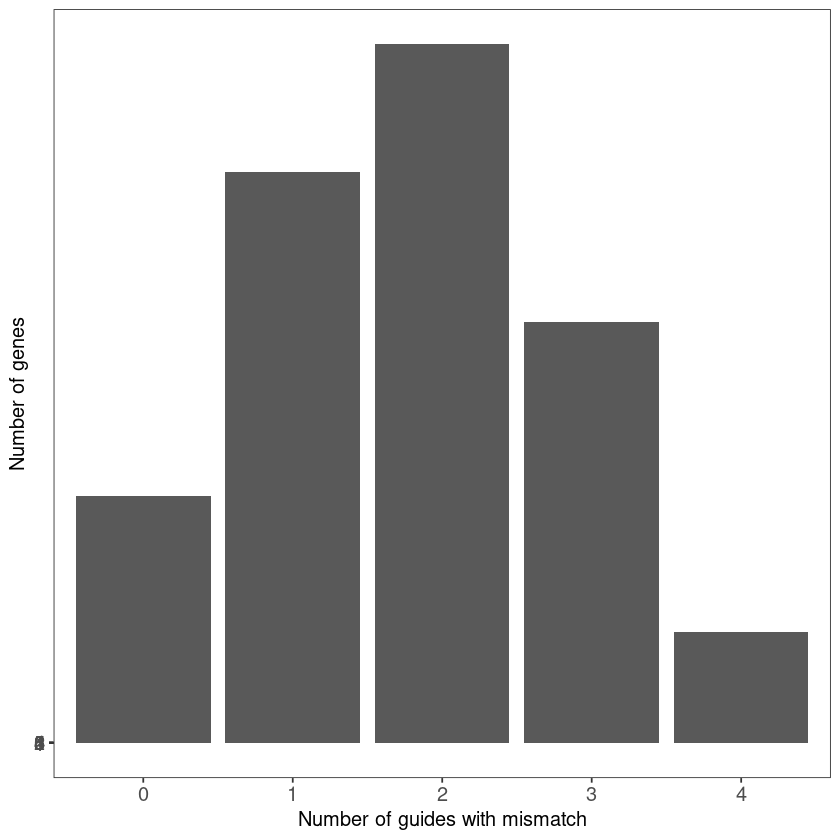

In [14]:
#Plot the plot
avana.affected.rate %>%
data.frame() %>%
filter(!str_detect(gene, 'INTERGENIC')) %>%
mutate(num_affected = as.numeric(num_affected)) %>%
filter(sgrna %in% all_of(avana.bed$sgrna)) %>%
mutate("is_affected" = ifelse(num_affected >= 1, 1, 0)) %>%
group_by(gene) %>%
summarise("num_guides_affected" = sum(is_affected)) %>%
group_by(num_guides_affected) %>%
summarise("num_genes_in_class" = n()) %>%
filter(num_guides_affected <= 4) %>%
ggplot(aes(x = as.character(num_guides_affected), y = num_genes_in_class)) +
geom_bar(stat = "identity") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_y_continuous(breaks = seq(1, 6, by = 1)) +

ylab("Number of genes") +
xlab("Number of guides with mismatch")

#Export it to the google bucket
setwd('../output')
ggsave("figure_3c.pdf", width = 5, height = 3)

In [15]:
#Also export the df
df_for_export = avana.affected.rate %>%
data.frame() %>%
filter(!str_detect(gene, 'INTERGENIC')) %>%
mutate(num_affected = as.numeric(num_affected)) %>%
filter(sgrna %in% all_of(avana.bed$sgrna)) %>%
mutate("is_affected" = ifelse(num_affected >= 1, 1, 0)) %>%
group_by(gene) %>%
summarise("num_guides_affected" = sum(is_affected)) %>%
group_by(num_guides_affected) %>%
summarise("num_genes_in_class" = n()) %>%
filter(num_guides_affected <= 4)

setwd("../output")
write.table(df_for_export, "figure_3c_avana_affected_rate.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)